In [1]:
# import the Libraries 
import numpy as np
import pandas as pd

#Maths stats
from numpy import mean, std
from math import sqrt

#data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

# scoring and cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RepeatedKFold

# ML algortihms regression
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

# Module perso : helpers
import helpers # Le module du fichier python helper.py

In [2]:
pd.set_option("display.max_row",6000)
pd.set_option("display.max_column",100)
pd.set_option("display.precision", 4)
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format # to make legible

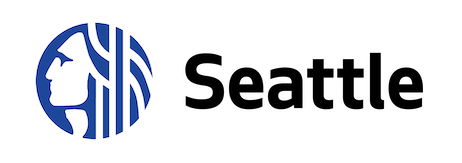

# <span class="bg-primary"> Modèle __Consommation d'énergie__ Seattle <span>
# <span class="bg-danger">Introduction<span>
    
__Buts de la mission:__
    
La ville de Seattle souhaite atteindre son objectif de ville neutre en émissions de carbone en 2050. Des relevés minutieux ont été effectués en __2015 et 2016__. Afin de poursuivre son ambitieux programme tout en en limitant le coût, la ville a besoin de prédictions. Trois objectifs principaux ont été fixés :
   
- <span class="bg-danger">Prédire, grâce à une modélisation, la consommation totale d'énergie de bâtiments<span> 
    
- _Prédire, grâce à une modélisation, leurs émissions de GES_
    
- _Evaluer la pertinence d'un indicateur d'efficacité énergétique appelé __Energy Star Score___.

# <span class="bg-danger">Sommaire<span>
    
__<span class="bg-info">1.<span>__ __Chargement et préparation des données__
    
__<span class="bg-warning">1_1.<span>__ Séparation des variables indépendantes et de la cible
___
__<span class="bg-warning">1_2.<span>__ Séparation du jeu de données train/test
___
__<span class="bg-warning">1_3.<span>__ Encodage
___
__<span class="bg-warning">1_4.<span>__ Standardisation
___    
__<span class="bg-warning">1_5.<span>__ Sauvegarde encodage/Standardisation avec Joblib
___
__<span class="bg-info">2.<span>__ __Apprentissage automatique__ : tester différents algorithmes de ML
___
__<span class="bg-warning">2_1.<span>__ Modèles linéaires
___
__<span class="bg-warning">2_2.<span>__ Modèles non linéaires
___
__<span class="bg-warning">2_3.<span>__ Bilan et sélection des algorithmes les plus performants
___   
__<span class="bg-info">3.<span>__ __Optimisations des hyperparamètres des 3 algorithmes retenus__
___
__<span class="bg-warning">3_1.<span>__ Random Forest (RandomizedSearchCV, GridSearchCV)
 ___
__<span class="bg-warning">3_2.<span>__ Extra trees (RandomizedSearchCV, GridSearchCV)
___
__<span class="bg-warning">3_3.<span>__ XGBOOST(GridSearchCV, 6 étapes)
___
__<span class="bg-warning">3_4.<span>__ Sélection du meilleur modèle (Performance/Durée d'exécution)   
___
__<span class="bg-warning">3_5.<span>__ Sauvegarde des modèles optimisés avec joblib    

__<span class="bg-info">4.<span>__ __Prédictions__
    
__<span class="bg-info">5.<span>__ __Complément : Sélection itérative des variables (RFECV)__

# <span class="bg-success">1. Chargement et préparation des données<span>

In [3]:
# import the dataset
data_etude = pd.read_csv('data_etude_nettoyage.csv')
data_etude.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
#sauvegarde séparée du energy star score
energy_star_score = data_etude['ENERGYSTARScore']
data_etude.drop('ENERGYSTARScore', axis=1, inplace=True)

## <span class="bg-info">1.1 Séparation des variables indépendantes et de la cible<span>

In [5]:
data_etude_encode = data_etude.copy()
#variables dépendantes
y = data_etude_encode.copy()[{'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 
                   'Log10_SiteEnergyUseWN(kBtu)', 'Log10_TotalGHGEmissions'}]
#variables indépendantes
X = data_etude_encode.copy().drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 
                        'Log10_SiteEnergyUseWN(kBtu)', 'Log10_TotalGHGEmissions',], axis=1)

## <span class="bg-info">1.2 Séparation du jeu de données train/test<span>

In [6]:
# split the dataset into test set and train set
X_train, X_test, y_train, y_test = train_test_split(X, y['Log10_SiteEnergyUseWN(kBtu)'], test_size = 0.2, random_state = 23)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2708, 20), (2708,), (677, 20), (677,))

## <span class="bg-info">1.3 Encodage<span>

In [7]:
#Variables qualitatives à encoder
X_train_categorical_columns =X_train[['BuildingType', 'Neighborhood', 'Outlier', 'PrimaryPropertyType','LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].columns 
X_test_categorical_columns =X_test[['BuildingType', 'Neighborhood', 'Outlier', 'PrimaryPropertyType','LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].columns

In [8]:
#encodage
encoder = TargetEncoder()
X_train[X_train_categorical_columns] = encoder.fit_transform(X_train[X_train_categorical_columns], y_train)
X_test[X_train_categorical_columns] = encoder.transform(X_test[X_test_categorical_columns])

C:\Users\Troussard Family\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## <span class="bg-info">1.4 Standardisation<span>

In [9]:
#Variables quantitatives à standardiser
X_train_numerical_columns =X_train[['CouncilDistrictCode', 'Latitude','Longitude','NumberofBuildings','NumberofFloors','YearBuilt' ,'PropertyGFABuilding(s)', 'RatioLargestUseGFA', 'RatioSecondUseGFA','RatioThirdUseGFA']].columns 
X_test_numerical_columns =X_test[['CouncilDistrictCode', 'Latitude','Longitude','NumberofBuildings','NumberofFloors','YearBuilt' ,'PropertyGFABuilding(s)', 'RatioLargestUseGFA', 'RatioSecondUseGFA','RatioThirdUseGFA']].columns

In [10]:
#centrer et réduire les données d'apprentissage
rs = RobustScaler()
X_train[X_train_numerical_columns] = rs.fit_transform(X_train[X_train_numerical_columns])
X_test[X_test_numerical_columns] = rs.transform(X_test[X_test_numerical_columns])

## <span class="bg-info">1.5 Sauvegarde encodage/standardisation avec joblib<span> 

In [11]:
#Utilisation de JobLib pour sérialiser et enregistrer l'encodage
from joblib import dump, load
# save encoding to disk
dump(encoder , 'encodage_saved.joblib', compress=1)

['encodage_saved.joblib']

In [12]:
#Utilisation de JobLib pour sérialiser et enregistrer la standardisation
from joblib import dump, load
# save to disk
dump(rs , 'standardisation_saved.joblib', compress=1)

['standardisation_saved.joblib']

# <span class="bg-success">2. Apprentissage automatique : tester différents algorithmes de ML<span>

## <span class="bg-info">2.1 Modèles linéaires<span> 

In [13]:
resultats = pd.DataFrame({})

### <span class="bg-warning">Régression linéaire non régularisée<span> 

In [14]:
#pour mesurer le temps
import time
deb_lr = time.time()

# Define the model
lin_reg = LinearRegression()

# Fit the model
lin_reg.fit(X_train,y_train)
#Prediction using test set 
y_pred = lin_reg.predict(X_test)
#time à la fin
fin_lr = time.time()

# Printing the metrics
mae_lr = mean_absolute_error(y_test, y_pred)
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
rmse_lr = sqrt(mse_lr)

#durée d'exécution
time_lr = fin_lr - deb_lr

Fonction __cross_validate__: 
   - 1. Elle permet de spécifier plusieurs mesures pour l'évaluation. 
   - 2. Elle renvoie un dict contenant les scores d'entraînement, les temps d'ajustement et les temps de pointage en plus du score de test.

In [15]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(lin_reg, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

In [16]:
resultats = resultats.append(pd.DataFrame({
    'Modèle' : ['Rég. linéaire Non_Régu'],
    'R2' : [r2_lr], 'MSE' : [mse_lr],'RMSE' : [rmse_lr], 'MAE' : mae_lr,
    'Durée' : [time_lr]}))
resultats

,Modèle,R2,MSE,RMSE,MAE,Durée
0,Rég. linéaire Non_Régu,0.58,0.52,0.72,0.55,0.01


### <span class="bg-warning">Régression linéaire régularisée : Ridge, Lasso, Elasticnet<span> 

In [17]:
#pour mesurer le temps
deb_el = time.time()
# Define the model
elastic = ElasticNet(alpha = 0.0001, l1_ratio = 0.3, tol = 0.01 , max_iter = 100000, normalize = True)

# Fit the model
elastic.fit(X_train, y_train)

#Prediction using test set 
y_pred = elastic.predict(X_test)
#time à la fin
fin_el = time.time()

# Metrics
mae_el = mean_absolute_error(y_test, y_pred)
mse_el = mean_squared_error(y_test, y_pred)
r2_el = r2_score(y_test, y_pred)
rmse_el = sqrt(mse_el)

#durée d'exécution
time_el = fin_el - deb_el

In [18]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(elastic, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

In [19]:
resultats = resultats.append(pd.DataFrame({
    'Modèle' : ['Rég. linéaire Régu'],
    'R2' : [r2_el], 'MSE' : [mse_el],'RMSE' : [rmse_el], 'MAE' : [mae_el],
    'Durée' : [time_el]}))
resultats

,Modèle,R2,MSE,RMSE,MAE,Durée
0,Rég. linéaire Non_Régu,0.58,0.52,0.72,0.55,0.01
0,Rég. linéaire Régu,0.56,0.53,0.73,0.55,0.00


### <span class="bg-warning">Support Vector Regressor<span>  

In [20]:
#pour mesurer le temps
deb_svr = time.time()
# Define the model
svr= SVR()

#Fit the model
svr.fit(X_train,y_train)

#Predicting using test set
y_pred=svr.predict(X_test)
#time à la fin
fin_svr = time.time()

# Metrics
mae_svr = mean_absolute_error(y_test, y_pred)
mse_svr = mean_squared_error(y_test, y_pred)
r2_svr = r2_score(y_test, y_pred)
rmse_svr = sqrt(mse_svr)

#durée d'exécution
time_svr = fin_svr - deb_svr

In [21]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(svr, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

In [22]:
resultats = resultats.append(pd.DataFrame({
    'Modèle' : ['SVR'],
    'R2' : [r2_svr], 'MSE' : [mse_svr],'RMSE' : [rmse_svr], 'MAE' : [mae_svr],
    'Durée' : [time_svr]}))
resultats

,Modèle,R2,MSE,RMSE,MAE,Durée
0,Rég. linéaire Non_Régu,0.58,0.52,0.72,0.55,0.01
0,Rég. linéaire Régu,0.56,0.53,0.73,0.55,0.00
0,SVR,0.65,0.43,0.66,0.48,0.28


## <span class="bg-info">2.2 Modèles non linéaires<span> 

### <span class="bg-warning">Arbres de décision<span> 

In [23]:
#pour mesurer le temps
deb_dt = time.time()
# Define the model
dt = DecisionTreeRegressor(random_state = 0)

# Fit the model
dt.fit(X_train,y_train)
#Predicting using test set 
y_pred = dt.predict(X_test)
#time à la fin
fin_dt = time.time()

# Printing the metrics
mae_dt = mean_absolute_error(y_test, y_pred)
mse_dt = mean_squared_error(y_test, y_pred)
r2_dt = r2_score(y_test, y_pred)
rmse_dt = sqrt(mse_dt)

#durée d'exécution
time_dt = fin_dt - deb_dt

In [24]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(dt, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

__Visualisation de l'arbre de décison, en limitant la profondeur à trois:__

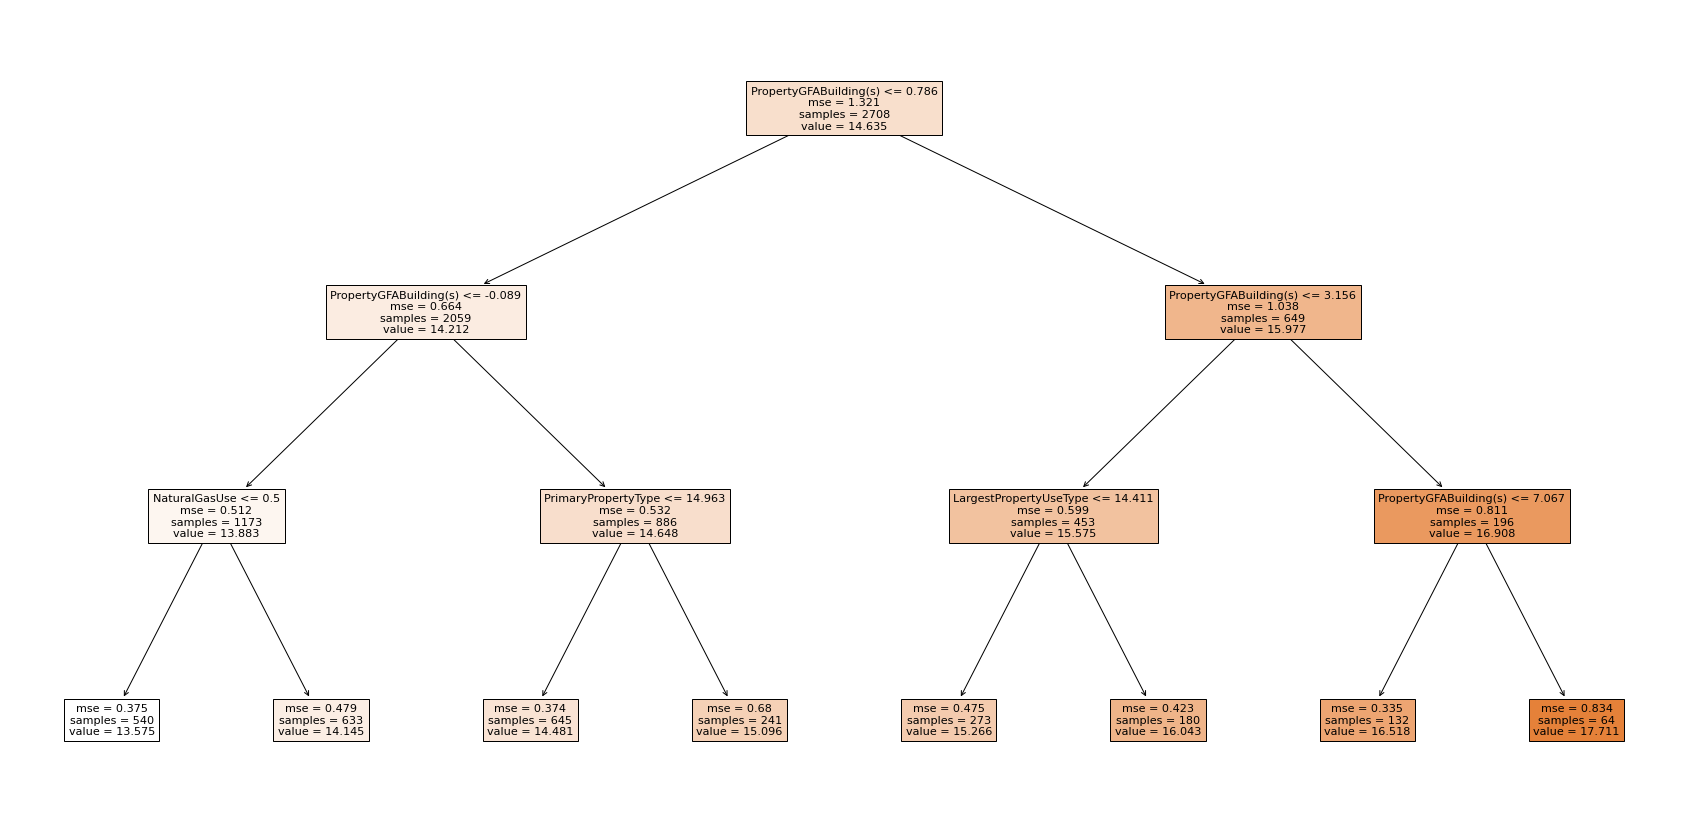

In [25]:
# Define the model
dt_viz = DecisionTreeRegressor(random_state = 0, max_depth = 3)
# Fit the model
dt_viz.fit(X_train,y_train)
#Predicting using test set 
y_pred = dt_viz.predict(X_test)

#visualization
plt.rcParams.update({'figure.figsize': (30.0, 15.0)})
from dtreeviz.trees import dtreeviz # will be used for tree visualization
_ = tree.plot_tree(dt_viz, feature_names=X_train.columns, filled=True)

In [26]:
resultats = resultats.append(pd.DataFrame({
    'Modèle' : ['ARBRE de DECISION'],
    'R2' : [r2_dt], 'MSE' : [mse_dt], 'RMSE' : [rmse_dt], 'MAE' : [mae_dt],
    'Durée' : [time_dt]}))
resultats

,Modèle,R2,MSE,RMSE,MAE,Durée
0,Rég. linéaire Non_Régu,0.58,0.52,0.72,0.55,0.01
0,Rég. linéaire Régu,0.56,0.53,0.73,0.55,0.00
0,SVR,0.65,0.43,0.66,0.48,0.28
0,ARBRE de DECISION,0.56,0.53,0.73,0.51,0.02


### <span class="bg-warning">Random Forest<span> 

In [27]:
#pour mesurer le temps
deb_rf = time.time()
# Define the model
rf = RandomForestRegressor(n_estimators = 750 ,  random_state = 0)

# Fit the model
rf.fit(X_train,y_train)

#Predicting using test set 
y_pred = rf.predict(X_test)
#time à la fin
fin_rf = time.time()

# Printing the metrics
mae_rf = mean_absolute_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
rmse_rf = sqrt(mse_rf)

#durée d'exécution
time_rf = fin_rf - deb_rf

In [28]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(rf, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

__Visualisation du premier arbre de la forêt, en limitant la profondeur à dix:__

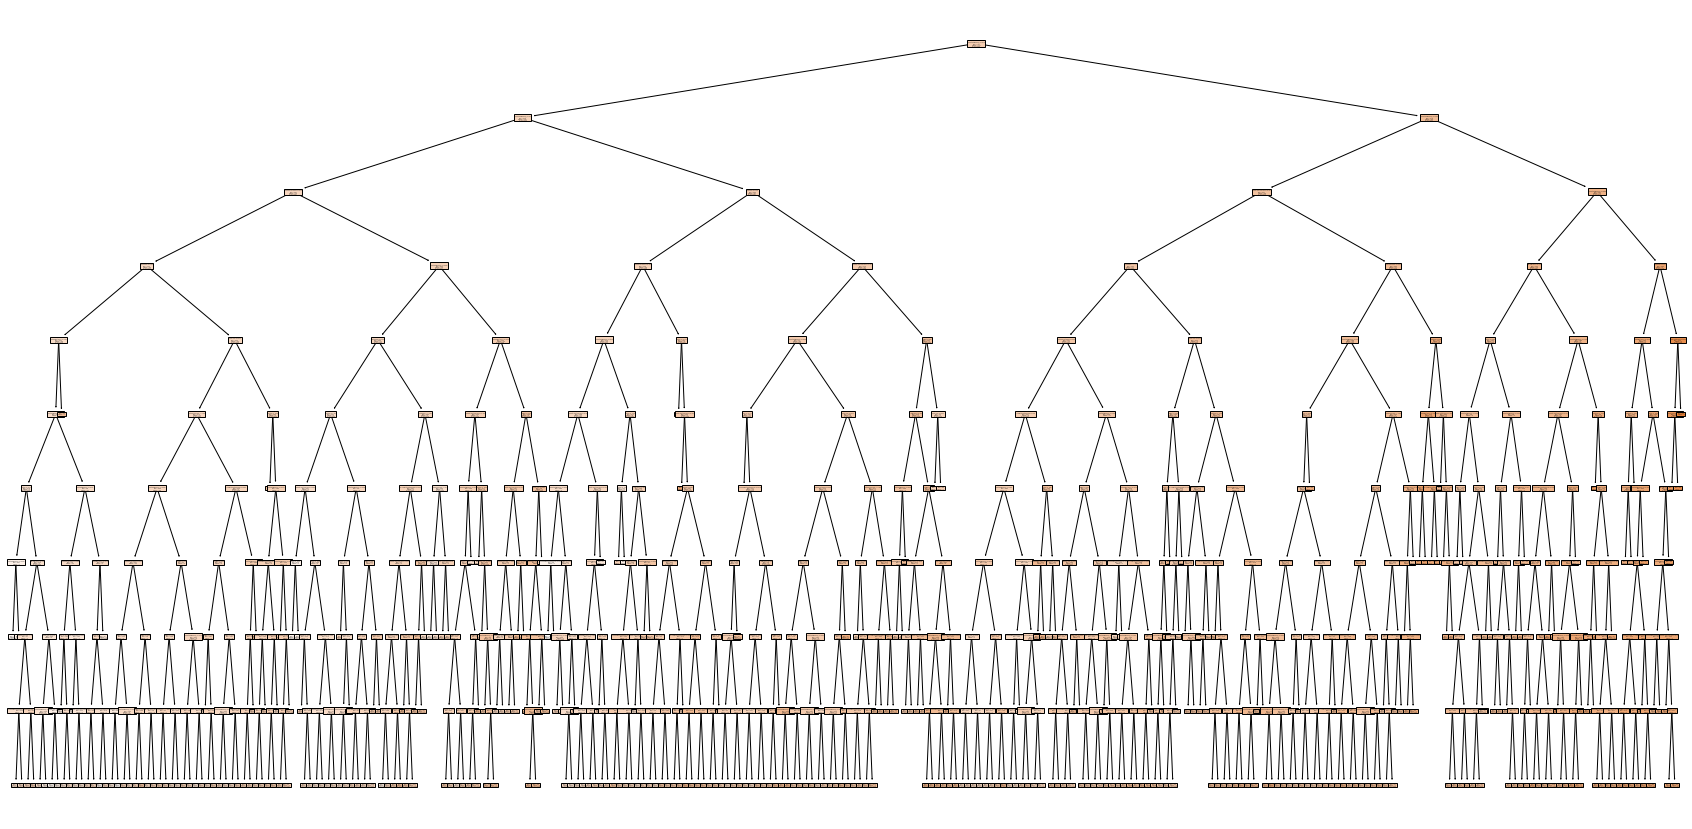

In [29]:
# Define the model
rf_viz = RandomForestRegressor(n_estimators = 750 ,  random_state = 0, max_depth = 10)
# Fit the model
rf_viz.fit(X_train,y_train)
#Predicting using test set 
y_pred = rf_viz.predict(X_test)

#visualization
plt.rcParams.update({'figure.figsize': (30.0, 15.0)})
from dtreeviz.trees import dtreeviz # will be used for tree visualization
_ = tree.plot_tree(rf_viz.estimators_[0], feature_names=X_train.columns, filled=True)

In [30]:
resultats = resultats.append(pd.DataFrame({
    'Modèle' : ['FORET ALEATOIRE'],
    'R2' : [r2_rf], 'MSE' : [mse_rf], 'RMSE' : [rmse_rf], 'MAE' : [mae_rf],
    'Durée' : [time_rf]}))
resultats

,Modèle,R2,MSE,RMSE,MAE,Durée
0,Rég. linéaire Non_Régu,0.58,0.52,0.72,0.55,0.01
0,Rég. linéaire Régu,0.56,0.53,0.73,0.55,0.00
0,SVR,0.65,0.43,0.66,0.48,0.28
0,ARBRE de DECISION,0.56,0.53,0.73,0.51,0.02
0,FORET ALEATOIRE,0.77,0.29,0.53,0.37,8.87


### <span class="bg-warning">Extra Trees<span> 

In [31]:
#pour mesurer le temps
deb_et = time.time()
# Define the model
et = ExtraTreesRegressor(random_state=0)

# Fit the model
et.fit(X_train, y_train)

#Predicting using test set
y_pred = et.predict(X_test)
#time à la fin
fin_et = time.time()

# Printing the metrics
mae_et= mean_absolute_error(y_test, y_pred)
mse_et= mean_squared_error(y_test, y_pred)
r2_et= r2_score(y_test, y_pred)
rmse_et = sqrt(mse_et)

#durée d'exécution
time_et = fin_et - deb_et

In [32]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(et, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

In [33]:
resultats = resultats.append(pd.DataFrame({
    'Modèle' : ['EXTRA TREES'],
    'R2' : [r2_et], 'MSE' : [mse_et], 'RMSE' : [rmse_et], 'MAE' : [mae_et],
    'Durée' : [time_et]}))
resultats

,Modèle,R2,MSE,RMSE,MAE,Durée
0,Rég. linéaire Non_Régu,0.58,0.52,0.72,0.55,0.01
0,Rég. linéaire Régu,0.56,0.53,0.73,0.55,0.00
0,SVR,0.65,0.43,0.66,0.48,0.28
0,ARBRE de DECISION,0.56,0.53,0.73,0.51,0.02
0,FORET ALEATOIRE,0.77,0.29,0.53,0.37,8.87
0,EXTRA TREES,0.77,0.28,0.52,0.37,0.84


### <span class="bg-warning">XGBoost<span> 

In [34]:
#pour mesurer le temps
deb_xgb = time.time()
# Define the model
xgb = XGBRegressor()

# Fit the model
xgb.fit(X_train, y_train)

#Predicting using test set
y_pred = xgb.predict(X_test)
#time à la fin
fin_xgb = time.time()

# Printing the metrics
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)
rmse_xgb = sqrt(mse_xgb)

#durée d'exécution
time_xgb = fin_xgb - deb_xgb

In [35]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(xgb, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

In [36]:
resultats = resultats.append(pd.DataFrame({
    'Modèle' : ['XGBOOST'],
    'R2' : [r2_xgb], 'MSE' : [mse_xgb], 'RMSE' : [rmse_xgb], 'MAE' : [mae_xgb],
    'Durée' : [time_xgb]}))
resultats

,Modèle,R2,MSE,RMSE,MAE,Durée
0,Rég. linéaire Non_Régu,0.58,0.52,0.72,0.55,0.01
0,Rég. linéaire Régu,0.56,0.53,0.73,0.55,0.00
0,SVR,0.65,0.43,0.66,0.48,0.28
0,ARBRE de DECISION,0.56,0.53,0.73,0.51,0.02
0,FORET ALEATOIRE,0.77,0.29,0.53,0.37,8.87
0,EXTRA TREES,0.77,0.28,0.52,0.37,0.84
0,XGBOOST,0.79,0.26,0.51,0.36,0.13


## <span class="bg-info">2.3 Bilan et sélection des  algorithmes les plus performants<span> 

### <span class="bg-warning">Tableau récapitulatif et visualisation de la performance<span> 

In [37]:
#Tableau performance (métriques diverses) et durée d'exécution
models = pd.DataFrame({
    'Model': ['REG. LIN NON REGU.', 'REG. LIN REGU.', 'SVR', 'ARBRE de DECISION', 'FORET ALEATOIRE', 'EXTRA TREES', 'XGBOOST'],
    'R2': [r2_lr, r2_el, r2_svr, r2_dt, r2_rf, r2_et, r2_xgb],
    'MSE': [mse_lr, mse_el, mse_svr, mse_dt, mse_rf, mse_et, mse_xgb],
    'RMSE': [rmse_lr, rmse_el, rmse_svr, rmse_dt, rmse_rf, rmse_et, rmse_xgb],
    'MAE': [mae_lr, mae_el, mae_svr, mae_dt, mae_rf, mae_et, mae_xgb],
    'DUREE': [time_lr, time_el, time_svr, time_dt, time_rf, time_et, time_xgb]
                      })
models.sort_values(by='R2', ascending=False)

,Model,R2,MSE,RMSE,MAE,DUREE
6,XGBOOST,0.79,0.26,0.51,0.36,0.13
5,EXTRA TREES,0.77,0.28,0.52,0.37,0.84
4,FORET ALEATOIRE,0.77,0.29,0.53,0.37,8.87
2,SVR,0.65,0.43,0.66,0.48,0.28
0,REG. LIN NON REGU.,0.58,0.52,0.72,0.55,0.01
1,REG. LIN REGU.,0.56,0.53,0.73,0.55,0.00
3,ARBRE de DECISION,0.56,0.53,0.73,0.51,0.02


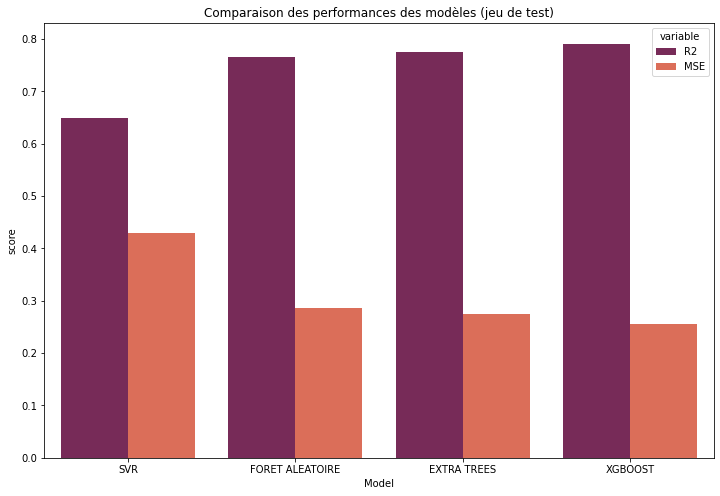

In [38]:
#Comparaison des 4 algorithmes les plus performants
comparaison_score = pd.DataFrame({
    'Model': ['SVR', 'FORET ALEATOIRE', 'EXTRA TREES', 'XGBOOST'],
    'R2': [r2_svr, r2_rf, r2_et, r2_xgb],
    'MSE': [mse_svr, mse_rf, mse_et, mse_xgb]})
comparaison_score_melt = pd.melt(comparaison_score, id_vars = ['Model'], value_name = 'score', value_vars=['R2', 'MSE'])
#Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = comparaison_score_melt['Model'],
            y = comparaison_score_melt['score'], hue = comparaison_score_melt['variable'], palette = "rocket" )
plt.title('Comparaison des performances des modèles (jeu de test)')
plt.show()

### <span class="bg-warning">Conclusion : algorithmes les plus performants<span> 

Trois modèles se détachent au niveau performance : __Forêt aléatoire (random forest)__ __Extra Trees__ et __XGBOOST__.

Notons dès à présent des différences dans la __durée d'exécution__ des différents algorithmes.

Ce sont ces trois modèles que nous gardons pour la phase d'__optimisation__ qui nous permettra de déterminer le __meilleur modèle__.

### Algorithmes retenus :

- __Random forest__
- __Extra Trees__
- __XGBOOST__

# <span class="bg-success">3. Optimisation des hyperparamètres des 3 algorithmes retenus<span> 

## <span class="bg-info">3.1 Random forest _(RandomizedSearchCV, GridSearchCV)_<span> 
    
__Principe__ : ensemble d'arbres décisionnel où a été introduit de l'aléatoire. Le résultat final est obtenu par vote majoritaire ou moyenne. (Tree bagging + feature sampling)
    
### <span class="bg-warning"> Recherche aléatoire avec validation croisée (RandomizedSearchCV de Scikit-Learn)<span>
    
En utilisant la méthode __RandomizedSearchCV de Scikit-Learn__, nous pouvons définir une grille de plages d'hyperparamètres et échantillonner __au hasard dans la grille__, en effectuant un CV K-Fold avec chaque combinaison de valeurs.    

In [39]:
# Création de la grille de recherche aléatoire

# Number of trees in random forest
n_estimators = [500, 600, 700, 800, 900, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 3, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 5, 10, 15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [40]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 5, 10,
                                                             15],
                                        'min_samples_split': [1, 2, 3, 5, 10,
                                                              15, 20],
                                        'n_estimators': [500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42)

In [41]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50}

In [42]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=50, min_samples_split=5, n_estimators=600)

Nous pouvons encore améliorer nos résultats en utilisant la recherche par grille pour nous concentrer sur les plages d'hyperparamètres les plus prometteuses trouvées dans la recherche aléatoire.

### Résultats de la recherche aléatoire :

- __max_depth__ = 50, 
- __min_samples_split__ = 15, 
- __n_estimators__ = 600
- __min_samples_leaf__ = 1

### <span class="bg-warning">Recherche sur grille avec validation croisée _(GridSearchCV de Scikit-Learn)_<span>
__Tuning__ = Optimisation des hyperparamètres, plus ils sont bien choisi plus le modèle est performant.

In [43]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50, 60],
    'min_samples_leaf': [0, 1, 2],
    'min_samples_split': [ 14, 15, 16],
    'n_estimators': [550, 600, 650, 700]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)

In [44]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [30, 40, 50, 60],
                         'min_samples_leaf': [0, 1, 2],
                         'min_samples_split': [14, 15, 16],
                         'n_estimators': [550, 600, 650, 700]})

In [45]:
grid_search.best_params_;

{'bootstrap': True,
 'max_depth': 60,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 550}

In [46]:
grid_search.best_estimator_;

RandomForestRegressor(max_depth=60, min_samples_split=14, n_estimators=550)

### <span class="bg-warning">Modèle Random forest optimisé<span>

In [47]:
#pour mesurer le temps
deb_rf2 = time.time()
# Define the model
rf2 = RandomForestRegressor(n_estimators = 550,
                           bootstrap = True,
                           max_depth = 60,
                           min_samples_leaf = 1,
                           min_samples_split = 14,
                           max_features = 'auto')

# Fit the model
rf2.fit(X_train,y_train)

#Predicting using test set 
y_pred = rf2.predict(X_test)
#time à la fin
fin_rf2 = time.time()

# Printing the metrics
mae_rf2 = mean_absolute_error(y_test, y_pred)
mse_rf2 = mean_squared_error(y_test, y_pred)
r2_rf2 = r2_score(y_test, y_pred)
rmse_rf2 = sqrt(mse_rf2)

#durée d'exécution
time_rf2 = fin_rf2 - deb_rf2

In [48]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(rf2, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=False)
# report performance
pd.DataFrame(scores).T

,0,1,2,3,4
fit_time,4.27,4.31,4.33,4.34,4.29
score_time,0.06,0.06,0.06,0.06,0.06
test_r2,0.76,0.77,0.74,0.78,0.76
test_neg_mean_squared_error,-0.36,-0.31,-0.31,-0.27,-0.30


### <span class="bg-warning">Visualisation des variables importantes d'après la forêt<span>

In [49]:
coefficients = abs(grid_search.best_estimator_.feature_importances_)
liste_coefs = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

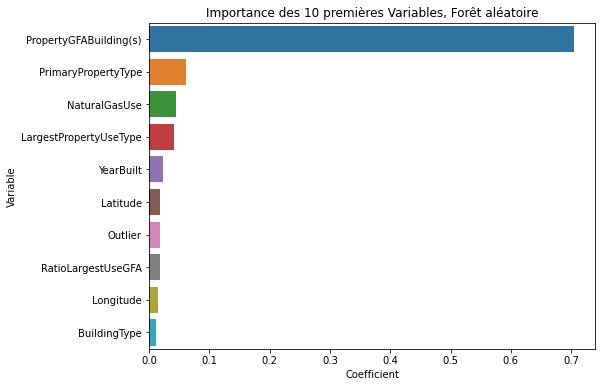

In [50]:
#Visualisation des 10 variables les plus importantes
import seaborn as sns
plt.figure(figsize=(8,6))
plt.title('Importance des 10 premières Variables, Forêt aléatoire')
sns.barplot(y = liste_coefs['Variable'].head(10),
            x = liste_coefs['Coefficient'].head(10))
plt.show()

## <span class="bg-info">3.2 Extra trees _(RandomizedSearchCV, GridSearchCV)_<span> 

### <span class="bg-warning"> Recherche aléatoire avec validation croisée (RandomizedSearchCV de Scikit-Learn)<span>

In [51]:
#Création de la grille de recherche aléatoire

# Number of trees in ET
n_estimators = [500, 700, 900, 1100, 1500, 1700, 2000, 2100, 2200]
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 3, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 5, 10, 15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [52]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
etrs = ExtraTreesRegressor()
# Random search of parameters, using 3 fold cross validation, 
et_random = RandomizedSearchCV(estimator = etrs, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
et_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 5, 10,
                                                             15],
                                        'min_samples_split': [1, 2, 3, 5, 10,
                                                              15, 20],
                                        'n_estimators': [500, 700, 900, 1100,
                                                         1500, 1700, 2000, 2100,
                                                         2200]},
                   random_state=42)

In [53]:
et_random.best_params_

{'n_estimators': 1700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [54]:
et_random.best_estimator_

ExtraTreesRegressor(max_depth=20, min_samples_split=15, n_estimators=1700)

Nous pouvons encore améliorer nos résultats en utilisant la recherche par grille pour nous concentrer sur les plages d'hyperparamètres les plus prometteuses trouvées dans la recherche aléatoire.

### Résultats de la recherche aléatoire :

- __max_depth__ = 20, 
- __min_samples_split__ = 15, 
- __n_estimators__ = 1700
- __min_samples_leaf__ = 1

### <span class="bg-warning">Recherche sur grille avec validation croisée _(GridSearchCV de Scikit-Learn)_<span>

In [55]:
# Create the parameter grid 
param_grid = {'n_estimators':[1600, 1700, 1800], 
              'max_depth':[10, 20, 30, 40],
              'min_samples_leaf': [0, 1, 2],
              'min_samples_split': [ 14, 15, 16],}
# Create a based model
et2 = ExtraTreesRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = et2, param_grid = param_grid, cv=10, n_jobs = -1, verbose = 0)

In [56]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [0, 1, 2],
                         'min_samples_split': [14, 15, 16],
                         'n_estimators': [1600, 1700, 1800]})

In [57]:
grid_search.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 1700}

### <span class="bg-warning">Modèle Extra Trees optimisé<span>

In [58]:
#pour mesurer le temps
deb_et2 = time.time()
# Define the model
et2 = ExtraTreesRegressor(n_estimators = 1700,
                          max_depth = 20, 
                          min_samples_leaf = 1,
                          min_samples_split = 14,)

# Fit the model
et2.fit(X_train,y_train)

#Predicting using test set 
y_pred = et2.predict(X_test)
#time à la fin
fin_et2 = time.time()

# Printing the metrics
mae_et2 = mean_absolute_error(y_test, y_pred)
mse_et2 = mean_squared_error(y_test, y_pred)
r2_et2=  r2_score(y_test, y_pred)
rmse_et2 = sqrt(mse_et2)

#durée d'exécution
time_et2 = fin_et2 - deb_et2

In [59]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(et2, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

## <span class="bg-info">3.3 XGBOOST _(GridSearchCV, 6 étapes)_<span> 

#### <span class="bg-warning">Pour comparaison, définissons un modèle XGB1 en laissant les hyperparamètres par défaut<span> 

In [60]:
#Modèle XGB par défaut

# Define the model
xgb_defaut = XGBRegressor()

# Fit the model
xgb_defaut.fit(X_train, y_train)

#Predicting using test set
y_pred = xgb_defaut.predict(X_test)

# Printing the metrics
mae_xgb_defaut =  mean_absolute_error(y_test, y_pred)
mse_xgb_defaut =  mean_squared_error(y_test, y_pred)
r2_xgb_defaut =  r2_score(y_test, y_pred)
rmse_xgb_defaut = sqrt(mse_xgb_defaut)
print(mse_xgb_defaut)
print(r2_xgb_defaut)

0.2553400299801541
0.7909057529921266


In [61]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(xgb_defaut, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T

,0,1,2,3,4
fit_time,0.09,0.08,0.08,0.08,0.08
score_time,0.00,0.00,0.00,0.00,0.00
test_r2,0.76,0.77,0.72,0.75,0.75
train_r2,0.98,0.98,0.98,0.99,0.99
test_neg_mean_squared_error,-0.37,-0.32,-0.33,-0.31,-0.32
train_neg_mean_squared_error,-0.02,-0.02,-0.02,-0.02,-0.02


#### <span class="bg-warning">Étape 1 : Fixer le taux d'apprentissage et le nombre d'estimateurs pour le réglage des paramètres basés sur les arbres<span> 
Afin de décider des paramètres de stimulation, nous devons fixer certaines valeurs initiales d'autres paramètres. 

In [101]:
param_test0 = {
 'n_estimators':range(100,1000,100),
 'learning_rate':[0.01, 0.05,0.1]   
}
gsearch0 = GridSearchCV(estimator = XGBRegressor(max_depth = 3, min_child_weight = 1, colsample_bytree = 0.8, subsample = 0.8, 
                                                 nthread=4, seed=27), 
param_grid = param_test0, scoring='r2',n_jobs=4, cv=10)
gsearch0.fit(X_train, y_train)
gsearch0.best_params_, gsearch0.best_score_

({'learning_rate': 0.05, 'n_estimators': 400}, 0.7828101717853694)

#### <span class="bg-warning">Modèle XGB2<span> 

In [106]:
# Modèle XGB2 obtenu par ajustement du taux d'apprentissage et du nombre d'estimateurs

# Define the model
xgb2 = XGBRegressor(learning_rate =0.05, n_estimators=400, max_depth = 3, min_child_weight = 1, colsample_bytree = 0.8, 
                    subsample = 0.8, nthread=4, seed=27)

# Fit the model
xgb2.fit(X_train, y_train)

#Predicting using test set
y_pred = xgb2.predict(X_test)

# Printing the metrics
mse_xgb2=metrics.mean_squared_error(y_test, y_pred)
r2_xgb2=metrics.r2_score(y_test, y_pred)
print(mse_xgb2)
print(r2_xgb2)

0.2512385625969296
0.7942643851431032


In [107]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(xgb2, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

#### <span class="bg-warning">Étape 2 : Régler max_depth et min_child_weight<span> 
Nous les réglons d'abord car ils auront le plus grand impact sur le résultat du modèle. Pour commencer, définissons des plages plus larges, puis nous effectuerons une autre itération pour des plages plus petites.

In [109]:
param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.05, n_estimators = 400, max_depth = 3, min_child_weight = 1, 
                                                  colsample_bytree = 0.8, subsample = 0.8, nthread = 4, seed = 27), 
param_grid = param_test1, scoring='r2',n_jobs=4, cv=10)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.7828101717853694)

Ici, nous avons exécuté 12 combinaisons avec des intervalles plus larges entre les valeurs. Les valeurs idéales sont __3 pour max_depth__ et __1 pour min_child_weight__. Allons un peu plus loin et cherchons les valeurs optimales. Nous allons chercher les valeurs 1 au-dessus et en dessous des valeurs optimales parce que nous avons pris un intervalle de deux.

In [111]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.05, n_estimators = 400, max_depth = 3, min_child_weight = 1, 
                                                  colsample_bytree = 0.8, subsample = 0.8, nthread = 4, seed = 27),
param_grid = param_test2, scoring='r2', n_jobs=4, cv=10)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.7828101717853694)

Ici, nous obtenons les valeurs optimales __3 pour max_depth__ et __1 pour min_child_weight__. 

#### <span class="bg-warning">Étape 3 : Régler le gamma<span> 
Réglons maintenant la valeur gamma en utilisant les paramètres déjà réglés ci-dessus. Le gamma peut prendre différentes valeurs, mais je vais vérifier 5 valeurs ici. 

In [112]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.05, n_estimators = 400, max_depth = 3, min_child_weight = 1, 
                                                  colsample_bytree = 0.8, subsample = 0.8, nthread = 4, seed = 27), 
param_grid = param_test3, scoring='r2', n_jobs=4, cv=10)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 0.7828101717853694)

#### <span class="bg-warning">Étape 4 : Régler subsample et colsample_bytree<span> 
L'étape suivante consisterait à essayer différentes valeurs de sous-échantillon et de colsample_bytree. Faisons cela en deux étapes également et prenons les valeurs 0.5,0.6,0.7,0.8,0.9 pour commencer.

In [113]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.05, n_estimators = 400, max_depth = 3, min_child_weight = 1, 
                                                 colsample_bytree = 0.8, subsample = 0.8, gamma = 0,
                                                 nthread = 4, seed = 27),
param_grid = param_test4, scoring='r2', n_jobs=4, cv=10)
gsearch4.fit(X_train, y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.7}, 0.7829123925905226)

In [115]:
param_test4 = {
 'subsample':[0.6, 0.7, 0.8],
 'colsample_bytree':[0.5, 0.6, 0.7]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.05, n_estimators = 400, max_depth = 3, min_child_weight = 1, 
                                                 colsample_bytree = 0.8, subsample = 0.8, gamma = 0,
                                                 nthread = 4, seed = 27), 
param_grid = param_test4, scoring='r2', n_jobs=4, cv=10)
gsearch4.fit(X_train, y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.5, 'subsample': 0.8}, 0.7831600364873328)

#### <span class="bg-warning">Étape 5 : Réglage des paramètres de régularisation<span>  
L'étape suivante consiste à appliquer la régularisation pour réduire le surapprentissage. 

In [116]:
param_test6 = {
 'reg_alpha':[0, 1e-13, 1e-12, 1e-10, 1e-9, 1e-8],
 'reg_lambda':[1e-1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9, 1]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.05, n_estimators = 400, max_depth = 3, min_child_weight = 1, 
                                                 colsample_bytree = 0.5, subsample = 0.8, gamma = 0,
                                                 nthread = 4, seed = 27),   
param_grid = param_test6, scoring='r2', n_jobs=4, cv=10)
gsearch6.fit(X_train, y_train)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-08, 'reg_lambda': 0.8}, 0.7844304627336796)

#### <span class="bg-warning">Étape 6 : Régler le taux d'apprentissage et le nombres d'arbres<span>  
Enfin, nous devrions recalculer le taux d'apprentissage et le nombre d'arbres. 

In [117]:
param_test7 = {
    'n_estimators':range(50,2000,200),
    'learning_rate':[0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
}
gsearch7 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.05, n_estimators = 400, max_depth = 3, min_child_weight = 1, 
                                                 colsample_bytree = 0.5, subsample = 0.8,  gamma = 0,
                                                 reg_alpha = 1e-08, reg_lambda = 0.8,
                                                 nthread=4, seed=27), 
param_grid = param_test7, scoring='r2', n_jobs=4, cv=10)
gsearch7.fit(X_train, y_train)
gsearch7.best_params_, gsearch7.best_score_

({'learning_rate': 0.05, 'n_estimators': 450}, 0.7848255565097632)

#### <span class="bg-warning">Modèle XGB3 après optimisation complète<span> 

In [140]:
#pour mesurer le temps
deb_xgb3 = time.time()
# Define the model
xgb3 = XGBRegressor(learning_rate = 0.04,
                   n_estimators = 440,
                   max_depth = 4,
                   min_child_weight = 1,
                   gamma = 0,
                   subsample = 0.8,
                   colsample_bytree = 0.5,
                   reg_alpha = 1e-08, 
                   reg_lambda = 0.8,
                   nthread = 4,
                   seed = 27)

# Fit the model
xgb3.fit(X_train, y_train)

#Predicting using test set
y_pred = xgb3.predict(X_test)
#time à la fin
fin_xgb3 = time.time()


# Printing the metrics
mae_xgb3 = mean_absolute_error(y_test, y_pred)
mse_xgb3 = mean_squared_error(y_test, y_pred)
r2_xgb3 = r2_score(y_test, y_pred)
rmse_xgb3 = sqrt(mse_xgb3)

#durée d'exécution
time_xgb3 = fin_xgb3 - deb_xgb3
print(mse_xgb3)
print(r2_xgb3)

0.24869195515726245
0.7963497650385439


In [143]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(xgb3, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

#### <span class="bg-warning">Visualisation de l'effet de l'optimisation des hyper-paramètres sur les métriques<span> 

In [144]:
pd.options.display.float_format = '{:.4f}'.format 
df_xgb_r2 = pd.DataFrame({'R2': [0.735, 0.746, 0.752]},
                      index = ['XGB1', 'XGB2', 'XGB3'])
df_xgb_mse = pd.DataFrame({'MSE': [0.315, 0.301, 0.294]},
                      index = ['XGB1', 'XGB2', 'XGB3'])
df_xgb_etape = pd.DataFrame({'R2': [0.773, 0.794, 0.795, 0.795, 0.798, 0.798, 0.799]},
                      index = ['ETAPE 0','ETAPE 1', 'ETAPE 2','ETAPE 3','ETAPE 4', 'ETAPE 5', 'ETAPE 6'])

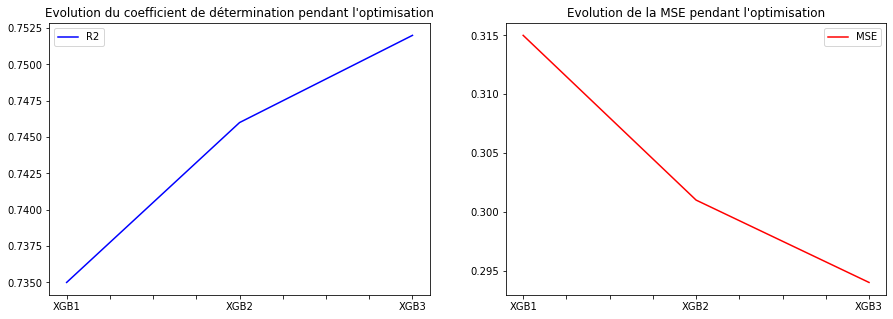

In [145]:
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5), sharex = False)
df_xgb_r2.plot(c = 'b', ax = ax1)
df_xgb_mse.plot(c = 'r', ax = ax2)
ax1.title.set_text('Evolution du coefficient de détermination pendant l\'optimisation')
ax2.title.set_text('Evolution de la MSE pendant l\'optimisation')

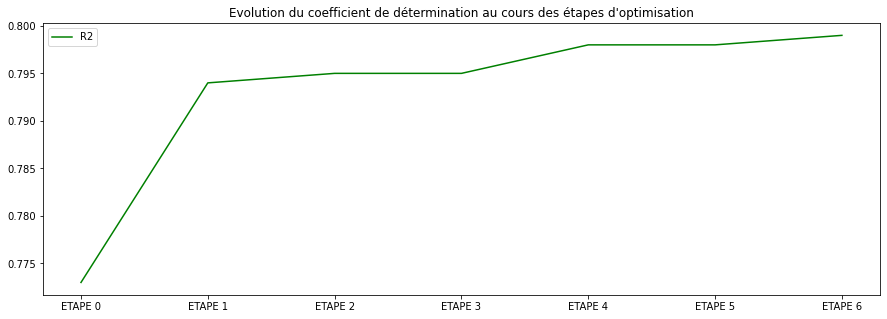

In [76]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,5), sharex = False)
df_xgb_etape.plot(c ='g', ax = ax)
ax.title.set_text('Evolution du coefficient de détermination au cours des étapes d\'optimisation')

## <span class="bg-info">3.4 Sélection du meilleur modèle (Performance/Durée d'exécution)<span> 

#### <span class="bg-warning">Comparaison graphique<span> 

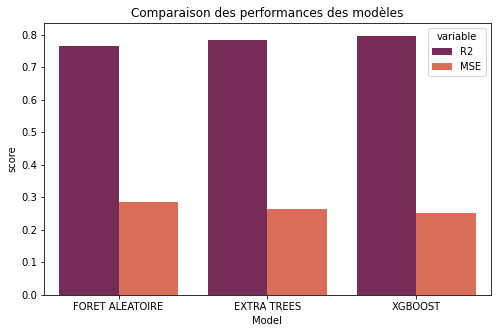

In [146]:
#Comparaison de la performance des modèles optimisés
comparaison_score = pd.DataFrame({
    'Model': ['FORET ALEATOIRE', 'EXTRA TREES', 'XGBOOST'],
    'R2': [r2_rf2, r2_et2, r2_xgb3],
    'MSE': [mse_rf2, mse_et2, mse_xgb2]})
comparaison_score_melt = pd.melt(comparaison_score, id_vars = ['Model'], value_name = 'score', value_vars=['R2', 'MSE'])
#Visualisation
plt.figure(figsize=(8,5))
sns.barplot(x = comparaison_score_melt['Model'],
            y = comparaison_score_melt['score'], hue = comparaison_score_melt['variable'], palette = "rocket" )
plt.title('Comparaison des performances des modèles')
plt.show()

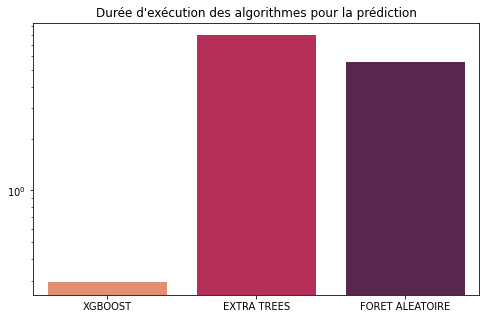

In [147]:
#Comparaison de la durée d'exécution
nom_modeles = [ 'XGBOOST', 'EXTRA TREES', 'FORET ALEATOIRE']
plt.figure(figsize = (8,5))
plt.title('Durée d\'exécution des algorithmes pour la prédiction')
sns.barplot(x=nom_modeles, y = [time_xgb3, time_et2, time_rf2], palette = "rocket_r")
ax = plt.gca()
ax.set_yscale('log')

#### <span class="bg-warning">Conclusion : meilleur modèle<span> 

__Le meilleur modèle, performance après optimisation et durée d'exécution est XGBOOST.__

## <span class="bg-info">3.5 Sauvegarde des modèles optimisés avec joblib<span> 

In [148]:
#Utilisation de JobLib pour sérialiser et enregistrer les modèles
from joblib import dump, load
# save the model to disk
dump([xgb3, et2, rf2] , 'regression_models_saved.joblib', compress=1)

['regression_models_saved.joblib']

# <span class="bg-success">4. Prédictions<span> 

## <span class="bg-info">Evaluation graphique des prédictions<span>  

In [149]:
X_test_essai = X_test
y_test_essai = y_test

In [163]:
#Modèle sauvegardé
xgb3_loaded, et2_loaded, rf2_loaded = load('regression_models_saved.joblib')
xgb3_loaded;

In [152]:
#Modèle prédiction xgb_pred
xgb_pred = XGBRegressor(learning_rate = 0.04,
                   n_estimators = 440,
                   max_depth = 4,
                   min_child_weight = 1,
                   gamma = 0,
                   subsample = 0.8,
                   colsample_bytree = 0.5,
                   reg_alpha = 1e-08, 
                   reg_lambda = 0.8)
# Fit the model
xgb_pred.fit(X_train, y_train)

#Predicting using train set
y_train_pred = xgb_pred.predict(X_train)

#Predicting using test set
y_test_pred = xgb_pred.predict(X_test_essai)
prediction = xgb_pred.predict(X_test_essai)

In [153]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(xgb_pred, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

Text(0, 0.5, 'y_test_pred')

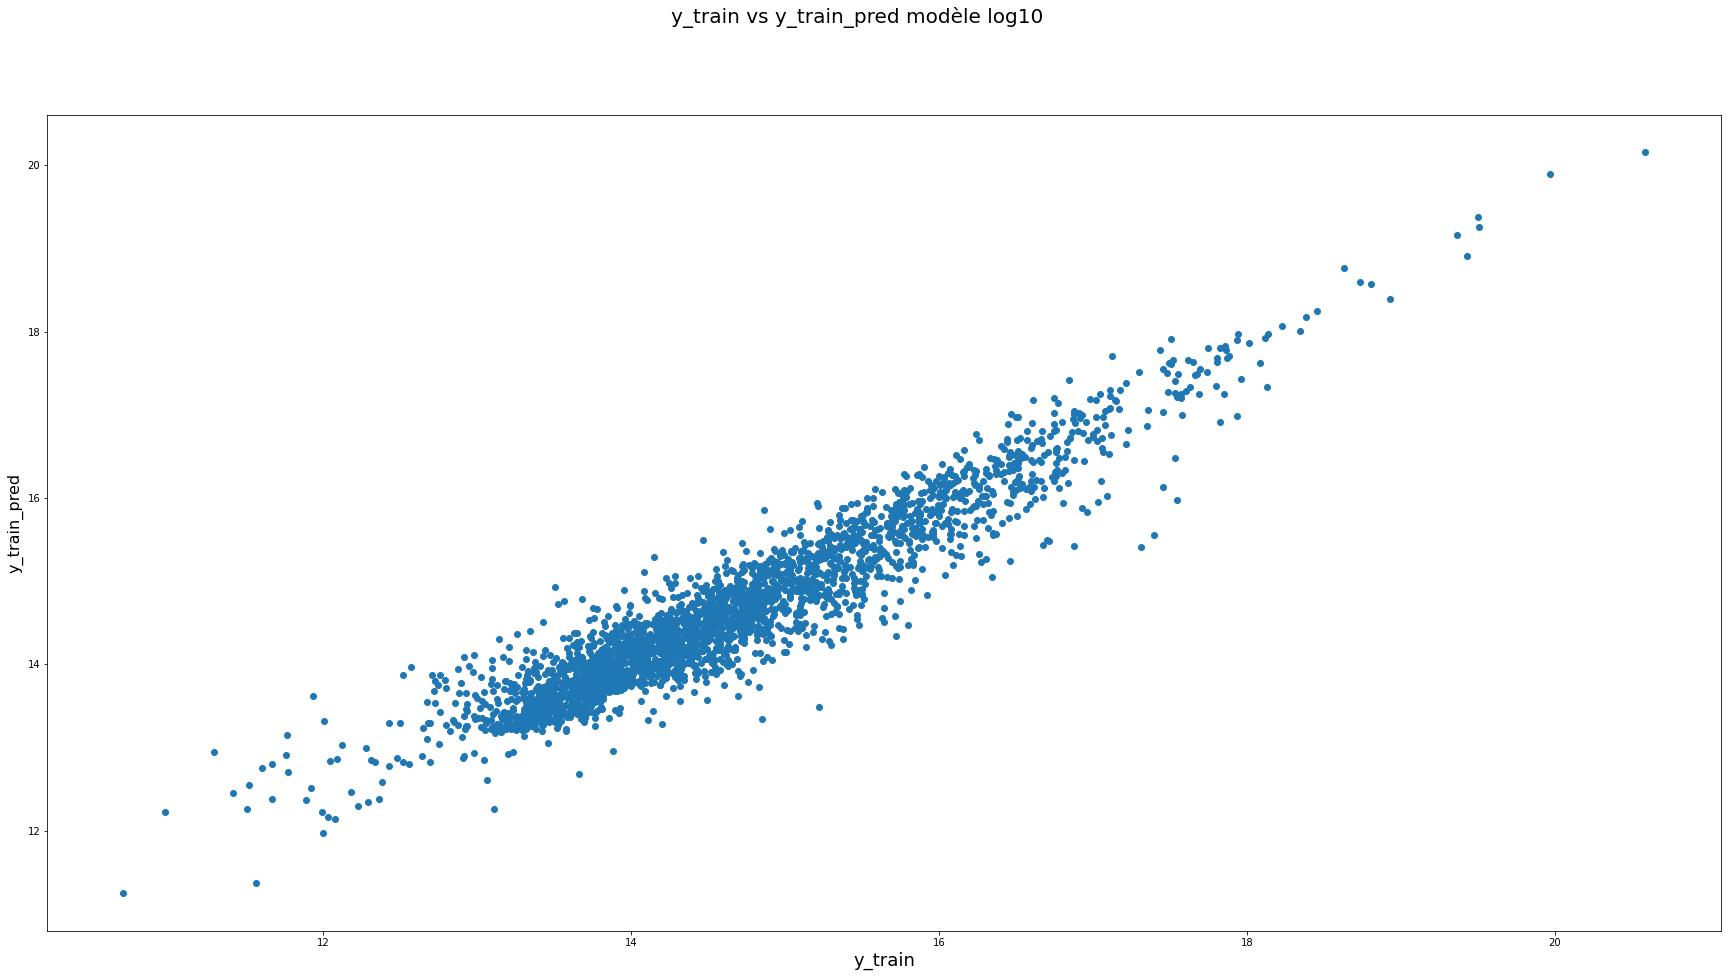

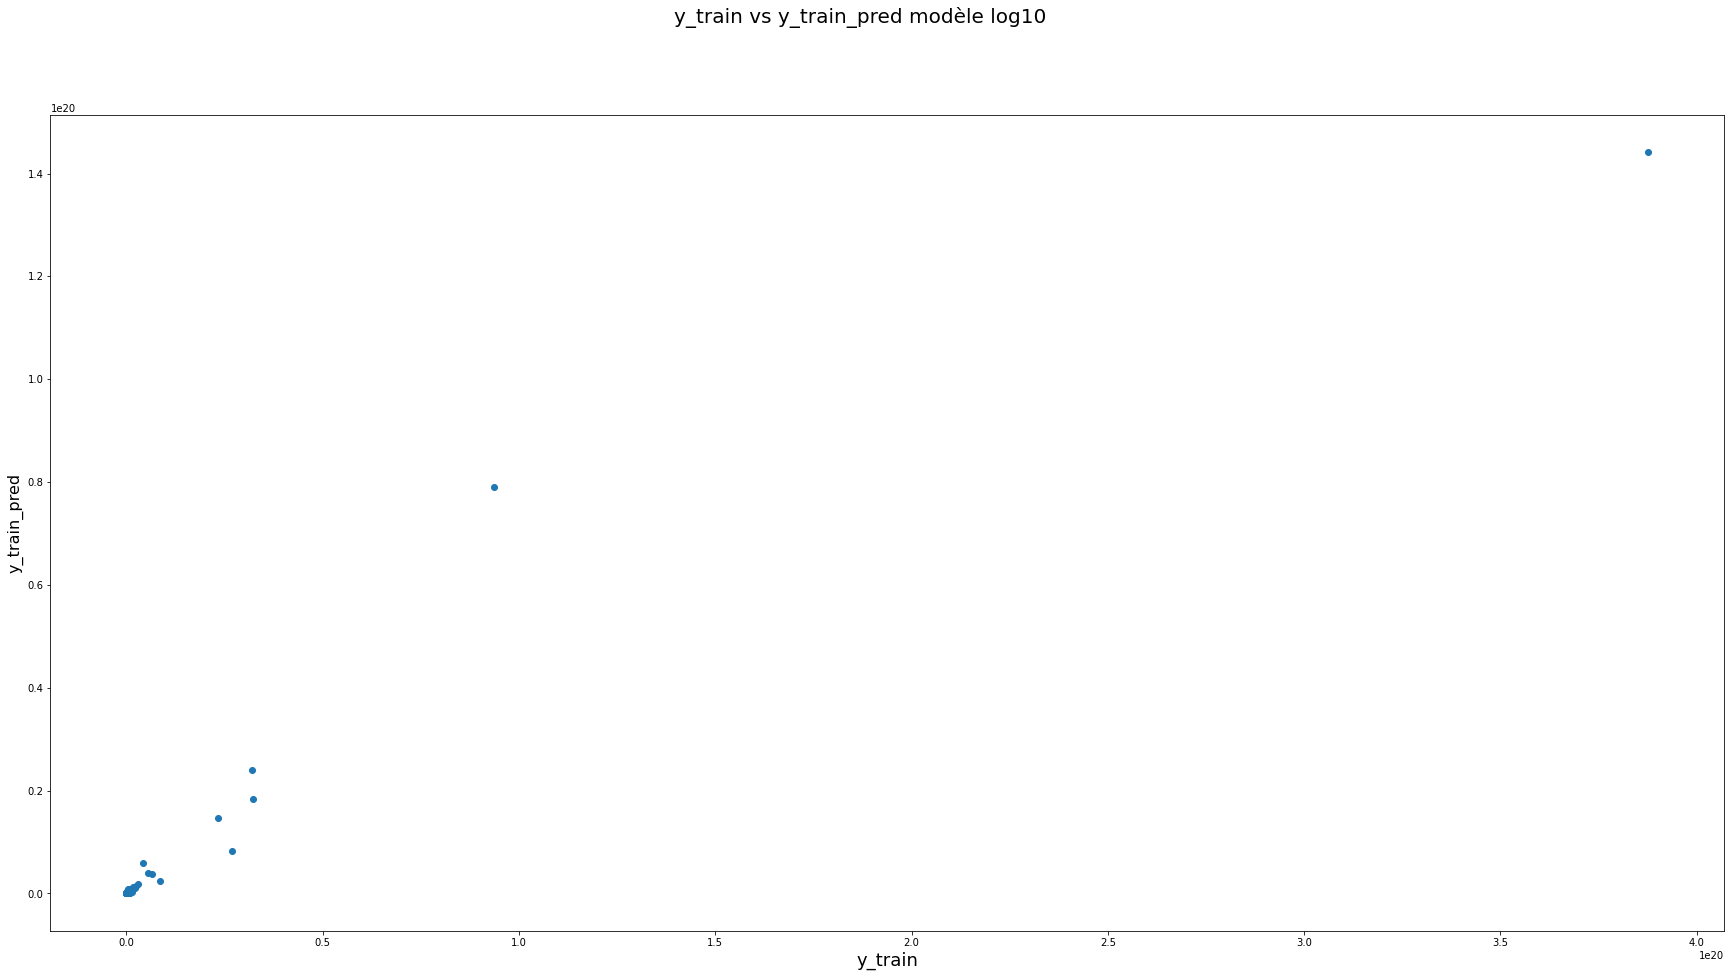

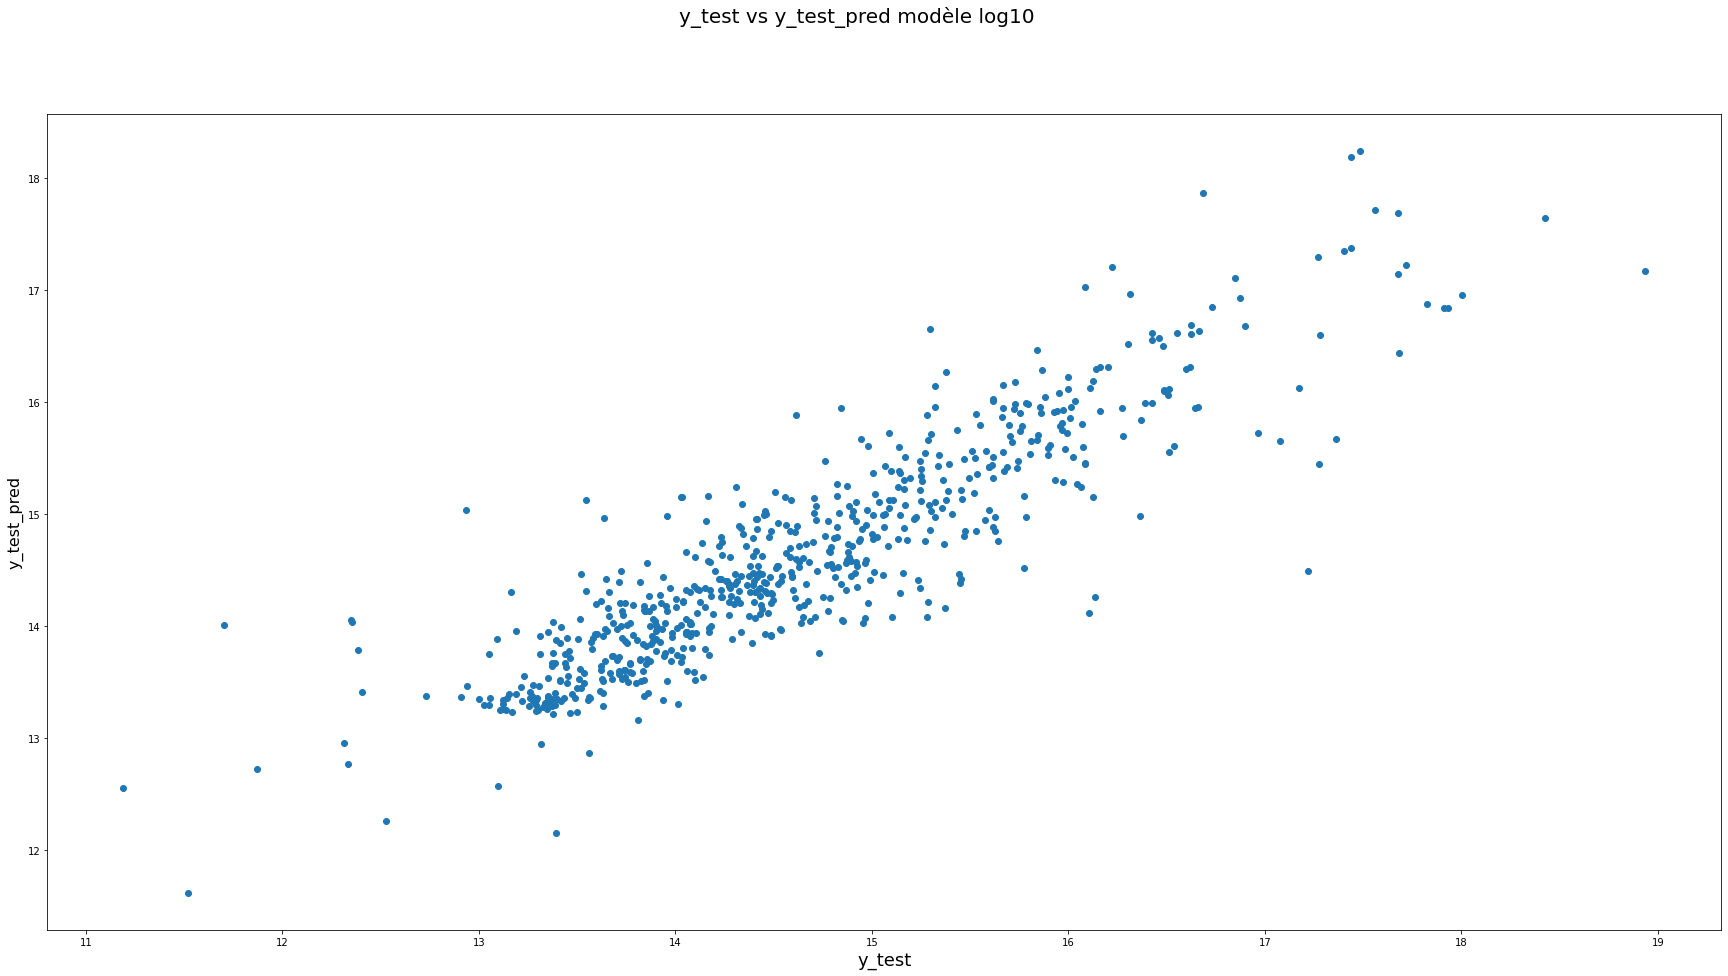

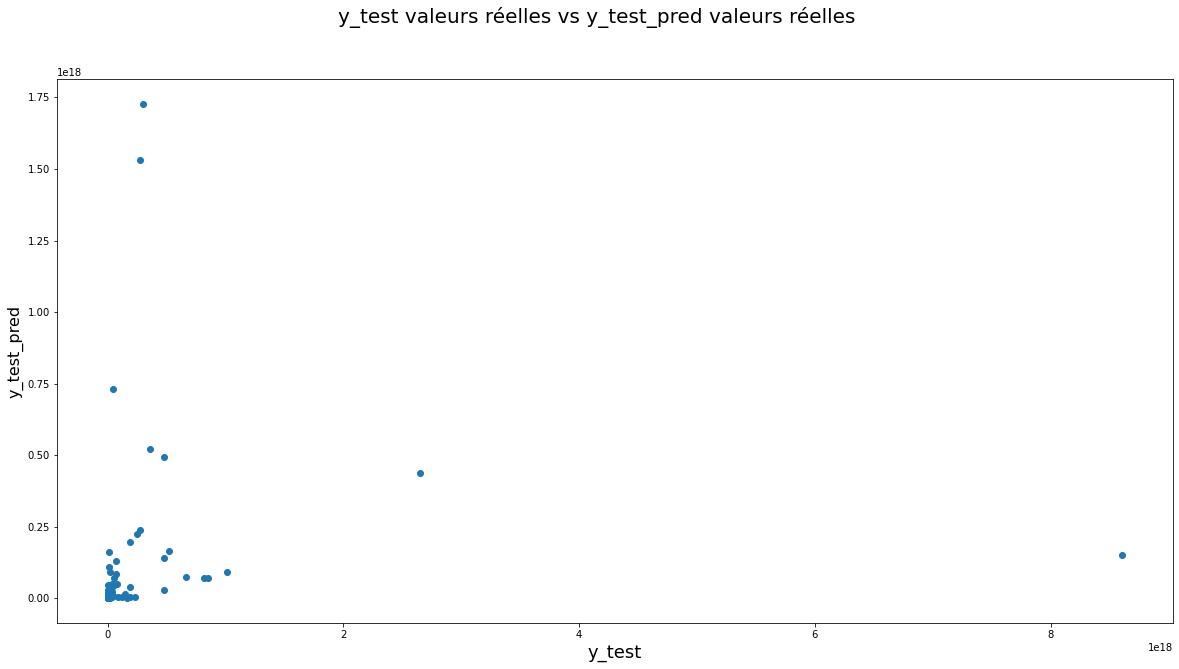

In [155]:
# Plotting y_test and y_test_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_train, y_train_pred)
fig.suptitle('y_train vs y_train_pred modèle log10', fontsize=20)        # Plot heading 
plt.xlabel('y_train', fontsize=18)                          # X-label
plt.ylabel('y_train_pred', fontsize=16)                     # Y-label


fig = plt.figure()
plt.scatter(10**y_train, 10**y_train_pred)
fig.suptitle('y_train vs y_train_pred modèle log10', fontsize=20)        # Plot heading 
plt.xlabel('y_train', fontsize=18)                          # X-label
plt.ylabel('y_train_pred', fontsize=16)                     # Y-label

fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_test_pred modèle log10', fontsize=20)         # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_test_pred', fontsize=16)                     # Y-label

#Ramenons la prédiction à l'unité qu'on cherche à prédire (inverse du log_10 soit 10^x)
fig = plt.figure(figsize=(20,10))
plt.scatter(10**y_test, 10**y_test_pred)
fig.suptitle('y_test valeurs réelles vs y_test_pred valeurs réelles', fontsize=20)         # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_test_pred', fontsize=16)                     # Y-label

# <span class="bg-success">5. Sélection itérative de variables<span> 

### <span class="bg-info">Sélection itérative de variables : RFE <span> 
L'algorithme __RFE (recursuve feature elimination)__ débute avec toutes les variables, construit un modèle, et rejette la variable la moins importante pour ce modèle. Un nouveau modèle est ensuite construit à partir des varaibles restantes, et ainsi de suite jusqu'à ce qu'il ne reste qu'un nombre prédéfini de variables. 

In [156]:
from sklearn.feature_selection import RFECV
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
correlated_features

set()

In [157]:
regressor = XGBRegressor(random_state=101)
selector = RFECV(estimator=regressor, step=1, scoring='neg_mean_squared_error', cv = 5)
selector.fit(X_train, y_train)

RFECV(cv=5,
      estimator=XGBRegressor(base_score=None, booster=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, gamma=None, gpu_id=None,
                             importance_type='gain',
                             interaction_constraints=None, learning_rate=None,
                             max_delta_step=None, max_depth=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             random_state=101, reg_alpha=None, reg_lambda=None,
                             scale_pos_weight=None, subsample=None,
                             tree_method=None, validate_parameters=None,
                             verbosity=None),
      scoring='neg_mean_squared_error')

In [158]:
print('Le nombre optimal de variables est {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]
print('Les variables sélectionnées sont:')
print ('{}'.format(features))

Le nombre optimal de variables est 18
Les variables sélectionnées sont:
['BuildingType', 'Neighborhood', 'Latitude', 'Longitude', 'Outlier', 'NumberofFloors', 'YearBuilt', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'PropertyGFABuilding(s)', 'RatioLargestUseGFA', 'RatioSecondUseGFA', 'RatioThirdUseGFA', 'SteamUse', 'ElectricityUse', 'NaturalGasUse']


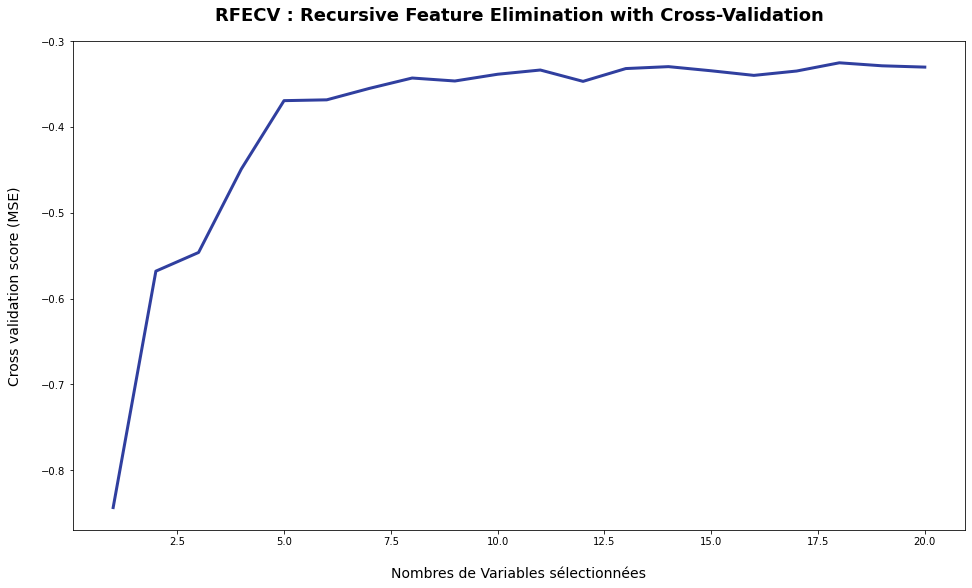

In [159]:
plt.figure(figsize=(16, 9))
plt.title('RFECV : Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Nombres de Variables sélectionnées', fontsize=14, labelpad=20)
plt.ylabel("Cross validation score (MSE)", fontsize=14, labelpad=20)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [160]:
print(np.where(selector.support_ == False)[0])

X_train.drop(X_train.columns[np.where(selector.support_ == False)[0]], axis=1, inplace = True)

[1 6]


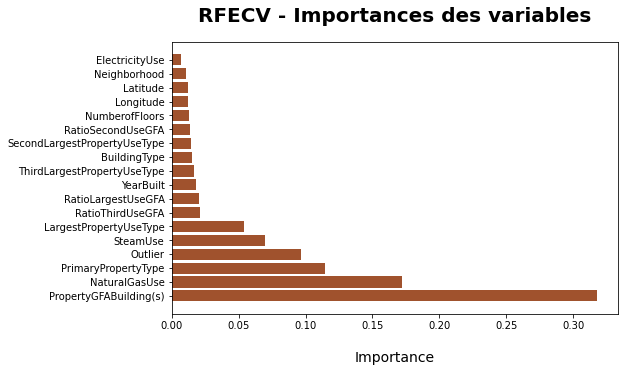

In [161]:
dset = pd.DataFrame()
dset['variables'] = X_train.columns
dset['importance'] = selector.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(8, 5))
plt.barh(y=dset['variables'], width=dset['importance'], color='sienna')
plt.title('RFECV - Importances des variables', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### <span class="bg-warning">Nouvel essai XGBOOST après sélection (18 variables retenues sur 20) <span> 

In [162]:
X_train_s = X_train[features]
X_test_s = X_test[features]

In [164]:
# Define the model
xgb4 = XGBRegressor(learning_rate = 0.04,
                   n_estimators = 440,
                   max_depth = 4,
                   min_child_weight = 1,
                   gamma = 0,
                   subsample = 0.8,
                   colsample_bytree = 0.5,
                   reg_alpha = 1e-08, 
                   reg_lambda = 0.8)

# Fit the model
xgb4.fit(X_train_s, y_train)

#Predicting using train set
y_train_pred = xgb4.predict(X_train_s)

#Predicting using test set
y_test_pred = xgb4.predict(X_test_s)

# Printing the metrics
mse_xgb4=metrics.mean_squared_error(y_test, y_test_pred)
r2_xgb4=metrics.r2_score(y_test, y_test_pred)
print('R2 square:', r2_xgb4)
print('MSE: ', mse_xgb4)

R2 square: 0.7976093658604158
MSE:  0.24715376596161398


In [165]:
#cross validate
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(xgb4, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

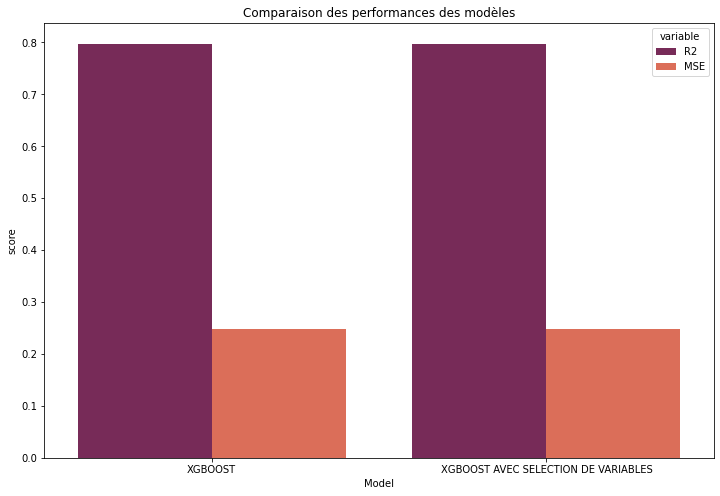

In [166]:
#Comparaison du modèle émission AVEC ou SANS sélection de variables
comparaison_score = pd.DataFrame({
    'Model': ['XGBOOST', 'XGBOOST AVEC SELECTION DE VARIABLES'],
    'R2': [ r2_xgb3, r2_xgb4],
    'MSE': [ mse_xgb3, mse_xgb4]})
comparaison_score_melt = pd.melt(comparaison_score, id_vars = ['Model'], value_name = 'score', value_vars=['R2', 'MSE'])
#Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = comparaison_score_melt['Model'],
            y = comparaison_score_melt['score'], hue = comparaison_score_melt['variable'], palette = "rocket" )
plt.title('Comparaison des performances des modèles')
plt.show() # Y-label

Le modèle avec sélection de variables montre une performance équivalente.